- Erics-MBP-3:Desktop Eric\$ mkdir dca-ls-analysis
- Erics-MBP-3:Desktop Eric\$ cd dca-ls-analysis
- Erics-MBP-3:dca-ls-analysis Eric$ virtualenv venv

### Imports

In [176]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np

### Pull Data
Note: I set up a venv to revert back to Python 2 since DataReader does not work on Python 3

In [128]:
# Pull data for spy, adj is split & dividend adjusted
start_date = datetime.datetime(1995, 6, 19) 
end_date = datetime.datetime(2020, 6, 19)
#end_date = datetime.datetime(2016, 1, 9)

spy_data = web.DataReader("SPY", "yahoo", start_date, end_date)

print(spy_data.tail()) # See first few rows

                  High         Low        Open       Close       Volume   Adj Close
Date                                                                               
2020-06-15  308.279999  296.739990  298.019989  307.049988  135782700.0  305.704712
2020-06-16  315.640015  307.670013  315.480011  312.959991  137627500.0  311.588806
2020-06-17  314.390015  310.859985  314.070007  311.660004   82954600.0  310.294525
2020-06-18  312.299988  309.510010  310.010010  311.779999   80828700.0  310.414001
2020-06-19  314.380005  306.529999  314.170013  308.640015  135239100.0  308.640015


### Define Functions

In [213]:
def lumpsum(invest_date, principal=10000): 
    invest_price = spy_data.loc[invest_date]['Adj Close']
    current_price = spy_data['Adj Close'][-1]
    
    investment_return = (current_price / invest_price) -1
    
    return principal*(1+investment_return)

In [214]:
def dollar_cost_average(invest_date, periods=12, freq='30D', principal=10000): 
    
    # Get DCA dates
    dca_dates =  investment_dates_all = pd.date_range(invest_date, periods=periods, freq=freq)
    
    # Filter out ones past the last data day
    dca_dates = dca_dates[dca_dates < spy_data.index[-1]]
    
    # Figure out how many dates we cut off
    cut_off_count = 12 - len(dca_dates)

    # Amount you have in cash and not the market
    value = cut_off_count*(principal/periods)
    
    for date in dca_dates:
        # Get an actual trading day
        trading_date = spy_data.index[spy_data.index.searchsorted(date)]

        # Calculate lumpsum value if invested on that date, add to value
        value += lumpsum(trading_date, principal= principal/periods)
    
    return value

### Analysis

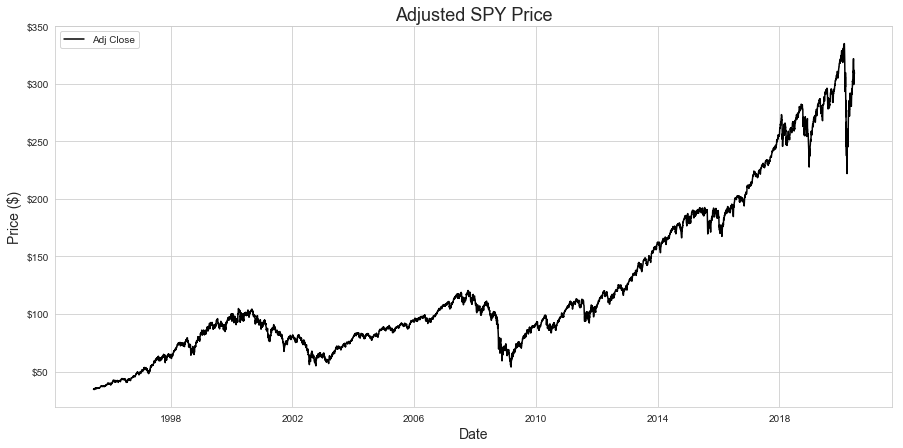

In [293]:
# Plot SPY 
spy_price = spy_data['Adj Close']

fig, ax = plt.subplots()

# Style and size
sns.set_style("whitegrid")
fig.set_size_inches(15, 7)

# Plot Series
ax.plot(spy_data.index, spy_price, color='black')

# Set Y axis format 
tick = ticker.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(tick) 
ax.set_title('Adjusted SPY Price', size=18)
ax.set_ylabel('Price ($)', size=14)
ax.set_xlabel('Date', size=14)


plt.legend()
plt.savefig('spy_chart.png')
plt.show()

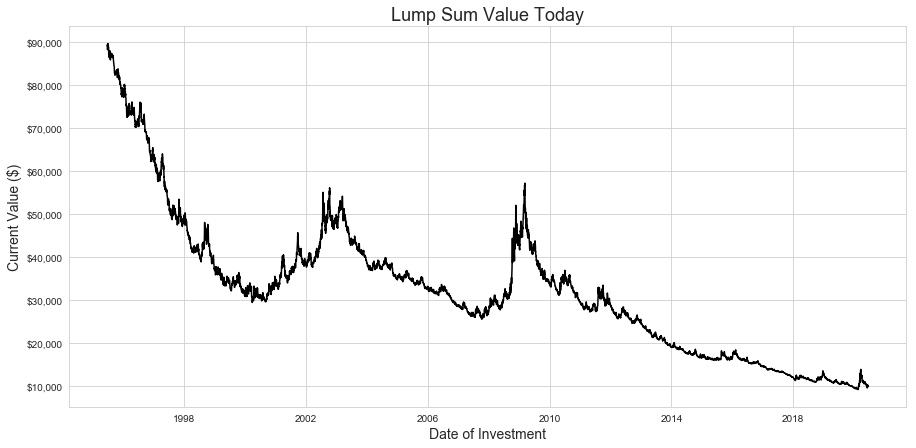

In [298]:
# Lump Sum 

# Simulate Lump Sum Investing
lump_sum = [lumpsum(x) for x in spy_data.index]

# Format and plots
sns.set_style("whitegrid")
plt.figure(figsize=(15, 6))
fig, ax = plt.subplots()

# Style and size
sns.set_style("whitegrid")
fig.set_size_inches(15, 7)

# Plot Series
ax.plot(spy_data.index, lump_sum, color='black')

# Set Y axis format 
tick = ticker.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(tick) 

# Labels
ax.set_title('Lump Sum Value Today', size=18)
ax.set_ylabel('Current Value ($)', size=14)
ax.set_xlabel('Date of Investment', size=14)

# Show with Legend
plt.legend()
plt.savefig('lumpsum.png')
plt.show()

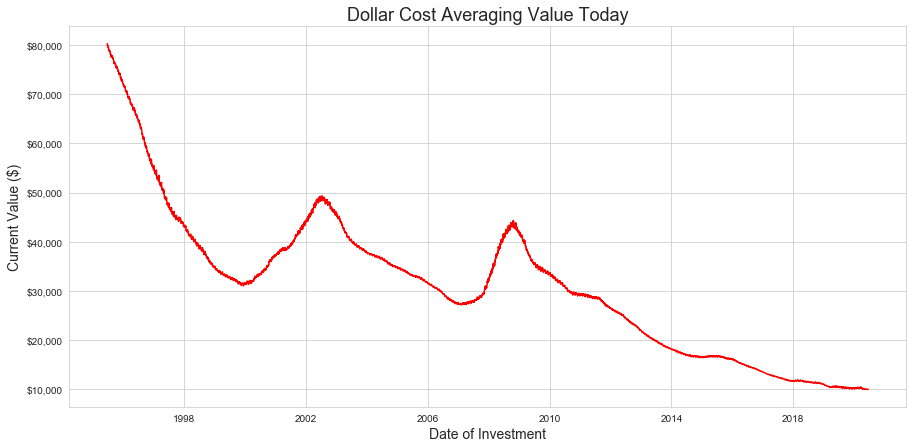

In [300]:
# Dollar Cost Average 

# Simulate DCA 
dca = [dollar_cost_average(i) for i in spy_data.index]

# Create Plot
fig, ax = plt.subplots()

# Style and size
sns.set_style("whitegrid")
fig.set_size_inches(15, 7)

# Plot Series
ax.plot(spy_data.index, dca, color='red')

# Set Y axis format 
tick = ticker.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(tick) 

# Labels
ax.set_title('Dollar Cost Averaging Value Today', size=18)
ax.set_ylabel('Current Value ($)', size=14)
ax.set_xlabel('Date of Investment', size=14)

# Show with Legend
plt.legend()
plt.savefig('dca.png')
plt.show()

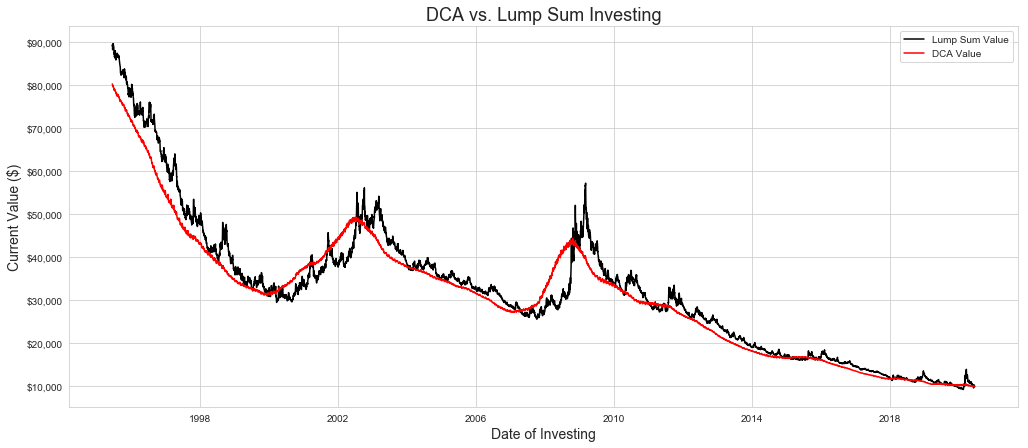

In [210]:
# Plot Together


# Style and size
fig, ax = plt.subplots()
sns.set_style("whitegrid")
fig.set_size_inches(17, 7)

# Plot Series
ax.plot(spy_data.index, lump_sum, color='black')
ax.plot(spy_data.index, dca, color='red')

# Set Y axis format 
tick = ticker.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(tick) 

# Labels
ax.set_title('DCA vs. Lump Sum Investing', size=18)
ax.set_ylabel('Current Value ($)', size=14)
ax.set_xlabel('Date of Investing', size=14)

plt.legend(['Lump Sum Value', 'DCA Value'])
plt.show()


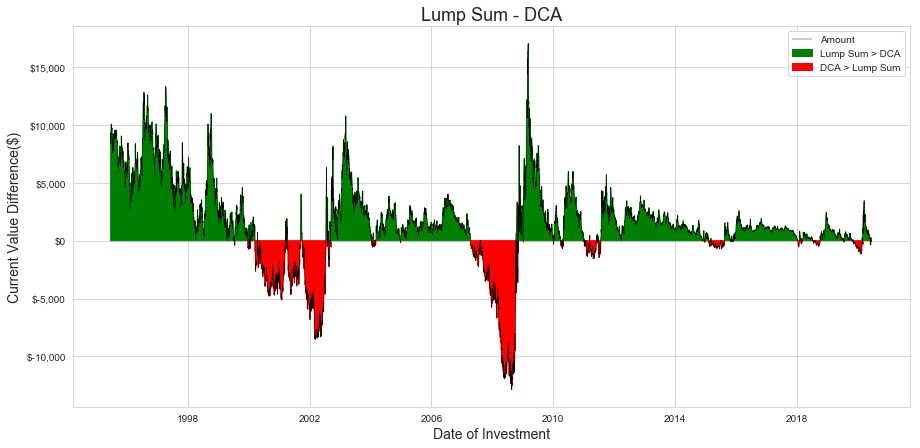

In [352]:
# Difference between strategies 

# Get difference with array operations
difference = np.array(lump_sum) - np.array(dca)

# Style and size
fig, ax = plt.subplots()
sns.set_style("whitegrid")
fig.set_size_inches(15, 7)

# Plot Series
ax.fill_between(spy_data.index, y1=difference, y2=0, color='green', where=difference > 0, edgecolor='black')
ax.fill_between(spy_data.index, y1=difference, y2=0, color='red', where=difference < 0, edgecolor='black')
ax.plot(spy_data.index, difference, color='black', linewidth=.4)

# Set Y axis format 
tick = ticker.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(tick) 

ax.set_title('Lump Sum - DCA', size=18)
ax.set_ylabel('Current Value Difference($)', size=14)
ax.set_xlabel('Date of Investment', size=14)

plt.legend(['Amount','Lump Sum > DCA', 'DCA > Lump Sum'])
plt.savefig('difference.png')
plt.show()

### Plot DCA Vs. Lump Sum Points


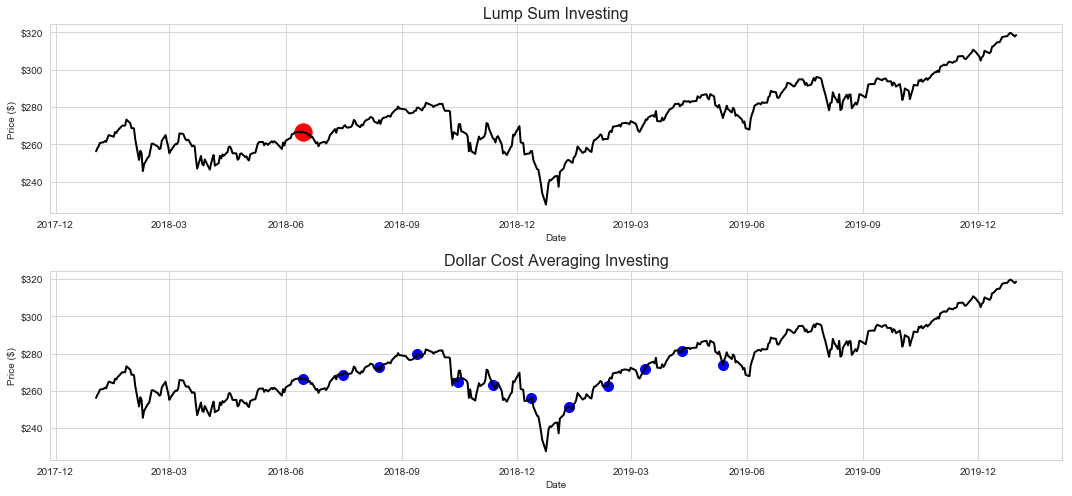

In [289]:
# Subset Data
spy_price_18 = spy_data['Adj Close'][np.logical_and(spy_data.index >= '1/1/2018',spy_data.index <= '12/31/2019')]

sns.set_style("whitegrid")
plt.figure(figsize=(15, 6))

fig, (ax1, ax2) = plt.subplots(2)

# Style and size
sns.set_style("whitegrid")
fig.set_size_inches(15, 7)

# Plot Series
ax1.plot(spy_price_18.index, spy_price_18, color='black', linewidth=2)


# Plot 1 point 
ax1.scatter('6/15/2018', spy_price_18[spy_price_18.index == '6/15/2018'], color='red', s=300)

# Set Y axis format 
tick = ticker.StrMethodFormatter('${x:,.0f}')
ax1.yaxis.set_major_formatter(tick) 
ax1.set_title('Lump Sum Investing', size=16)
ax1.set_ylabel('Price ($)')
ax1.set_xlabel('Date')


# Plot Series
ax2.plot(spy_price_18.index, spy_price_18, color='black', linewidth=2)


# Plot Points
dates = pd.date_range('6/15/2018', periods=12, freq='30D')
for date in dates:
        # Get an actual trading day
        trading_date = spy_data.index[spy_data.index.searchsorted(date)]
        ax2.scatter(trading_date, spy_price_18[spy_price_18.index == trading_date], color='blue', s=100)

# Set Y axis format 
tick = ticker.StrMethodFormatter('${x:,.0f}')
ax2.yaxis.set_major_formatter(tick) 
ax2.set_title('Dollar Cost Averaging Investing', size=16)
ax2.set_ylabel('Price ($)')
ax2.set_xlabel('Date')


fig.tight_layout()

plt.savefig('ls_dca_example_dots.png')
plt.show()



### Plot SPY, LS & DCA, and Difference

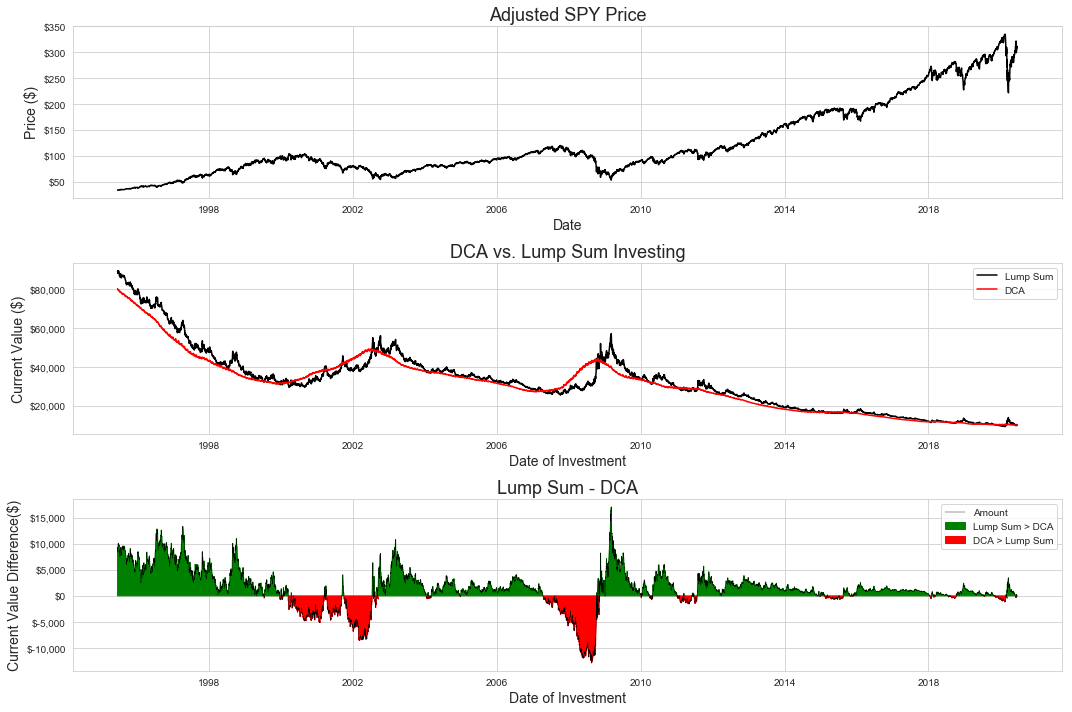

In [357]:

# Create Plots
fig, (ax1, ax2, ax3) = plt.subplots(3)

# Style and size
sns.set_style("whitegrid")
fig.set_size_inches(15, 10)

###### SPY Plot
ax1.plot(spy_data.index, spy_price, color='black')

# Set Y axis format 
tick = ticker.StrMethodFormatter('${x:,.0f}')
ax1.yaxis.set_major_formatter(tick) 
ax1.set_title('Adjusted SPY Price', size=18)
ax1.set_ylabel('Price ($)', size=14)
ax1.set_xlabel('Date', size=14)


###### LS & DCA Plot
# Plot Series
ax2.plot(spy_data.index, lump_sum, color='black')
ax2.plot(spy_data.index, dca, color='red')

# Set Y axis format 
tick = ticker.StrMethodFormatter('${x:,.0f}')
ax2.yaxis.set_major_formatter(tick) 

# Labels
ax2.set_title('DCA vs. Lump Sum Investing', size=18)
ax2.set_ylabel('Current Value ($)', size=14)
ax2.set_xlabel('Date of Investment', size=14)

ax2.legend(['Lump Sum', 'DCA'])

###### Difference Plot
# Plot Series
ax3.fill_between(spy_data.index, y1=difference, y2=0, color='green', where=difference > 0, edgecolor='black')
ax3.fill_between(spy_data.index, y1=difference, y2=0, color='red', where=difference < 0, edgecolor='black')
ax3.plot(spy_data.index, difference, color='black', linewidth=.4)

# Set Y axis format 
tick = ticker.StrMethodFormatter('${x:,.0f}')
ax3.yaxis.set_major_formatter(tick) 

ax3.set_title('Lump Sum - DCA', size=18)
ax3.set_ylabel('Current Value Difference($)', size=14)
ax3.set_xlabel('Date of Investment', size=14)
ax3.legend(['Amount','Lump Sum > DCA', 'DCA > Lump Sum'])

fig.tight_layout()
plt.savefig('all_plots.png')
plt.show()

In [348]:
print("Lump sum beats Dollar Cost Averaging {:.2f}% of the time".format((100*sum(difference>0)/len(difference))))

Lump sum beats Dollar Cost Averaging 76.48% of the time
